## Neural Architecture Search: A probabilistic Approach

In this project, we introduce the Bayesian Optimization (BO) implementation of the NAS algorithm that is exploiting patterns found in most optimal unique architectures sampled from the most popular NAS dataset and benchmarking tool NASbench-101. The proposed solution leverages a novel approach to path-encoding and is designed to perform reproducible search even on a relatively small initial batch obtained from the random search. This implementation does not require any special hardware, it is publicly available.

As a side result of this project, we've developed an WEB-based explanatory tool to explore similar architectures on training time vs test accuracy chart.

To reproduce the results of this work you will need to:

- Clone this repository
- Install needed dependencies pip install -r requirements.txt
- Download NASbench 108 epoch file from https://storage.googleapis.com/nasbench/nasbench_only108.tfrecord
- Put this nasbench file under neural-architecture-search/models folder


In [1]:
from data import Data
from scipy.optimize import curve_fit
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from utils import timestamp
from bo import BOArchitecture
import math

Some of the values below could be adjusted because they are hyperparameters.
Increasing `BATCH_SIZE` would result in a higher initial budget needed, however, it would provide better clusters.
Updating `OPT_K` is meaningful only if KMeans will be used. 
However, other clustering algorithms could be used, such as [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html).

In [2]:
# This is customizable
seed = 50 # random seed to guarantee reproducibility of results
OPT_K = 50 # number of K in Kmeans clustering
BREED_LEN = 5 # number of perspective patterns to explore during BO stage
SIMILARITY_TOLERANCE = 0.9 # probability level that defines if element constructs a pattern;
BATCH_SIZE = 1000
# This is not customizable
MAX_VERTICES = 7 # NOT A HYPERPARAMETER; This is a nasbench setting
MAX_EDGES = 9 # NOT A HYPERPARAMETER; This is a nasbench setting

In [3]:
dt = Data(seed)

Loading dataset from file... This may take a few minutes...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Loaded dataset in 76 seconds


There is no special way of querying architectures from NasBench-101. We are randomly generating adjacency matrices of size 7x7 and validating their uniqueness. We use only one operation at each edge - 3x3 Convolution with batch normalization and RELU as the activation function.

In [4]:
df, random_cells, random_results = dt.query_batch(BATCH_SIZE)

  0%|          | 1/1000 [00:00<01:40,  9.92it/s]

I01DT: Collecting unique architectures


  6%|▌         | 58/1000 [00:00<00:03, 291.59it/s]

I02DT: Evaluating unique architectures


100%|██████████| 1000/1000 [00:03<00:00, 312.73it/s]

I03DT: Saving log df of observations
I04DT: Plotting observed data


In [5]:
df

,trainable_parameters,training_time,train_accuracy,validation_accuracy,test_accuracy
hash,,,,,
-9120657472897549414,12945034,2096.432129,1.000000,0.933093,0.933694
6339845707480362952,12508170,1926.893066,0.999900,0.912460,0.909756
-3299044524765636419,5755750,1578.025024,1.000000,0.936498,0.934195
-7909289459038051150,49105546,5186.331055,1.000000,0.940405,0.934696
-4915730899984824701,13381898,2241.419922,1.000000,0.936599,0.937200
...,...,...,...,...,...
-2075685160260107957,12945034,2112.490967,1.000000,0.922075,0.922776
-2820595508002491435,13381898,3130.496094,1.000000,0.937800,0.928886
6395124334897435507,48231818,5072.527832,1.000000,0.927284,0.919671


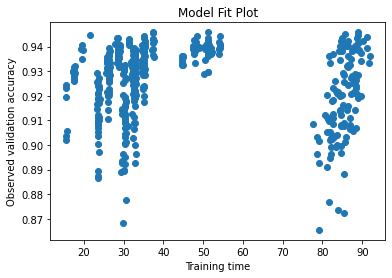

In [14]:
fig, ax = plt.subplots()
ax.scatter(df['training_time'] / 60, df['validation_accuracy'])
ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed validation accuracy')
ax.set_xlabel('Training time');

We are interested in the top-left corner of the chart above meaning that we are searching for architectures at the edge of Pareto frontier.

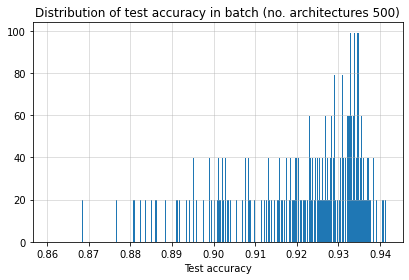

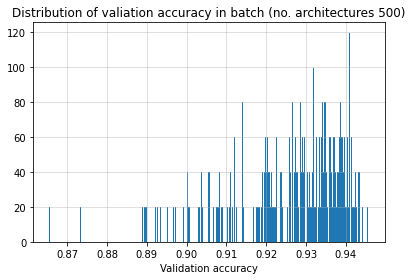

In [15]:
dt.plot_data(df)

100%|██████████| 2/2 [00:00<00:00, 12.09it/s]


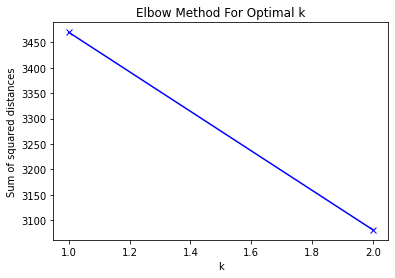

In [7]:
cell_structures = [np.asarray(random_cells[str(h)]['matrix']).reshape(-1) for h in df.index]
sum_of_squared_distances = []
K = range(1,3)
cell_structures
for k in tqdm(K):
    km = KMeans(n_clusters=k, random_state = seed)
    km = km.fit(cell_structures)
    sum_of_squared_distances.append(km.inertia_)

plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
t = timestamp()
plt.savefig('figures/sum_of_squares' + str(t) + '.pdf', dpi=600)
plt.show()

The cell above is an overview of the effectiveness of KMeans. This chart would be usually very similar non-depending on batch size. We usually use OPT_K = 50. However, we encourage the usage of other clustering algorithms.

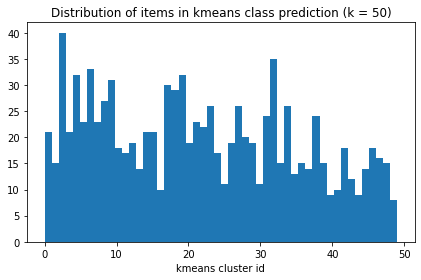

In [8]:
# Below default OPT_K is 50; This is not optimal, but since we are limited with budget of initial sample
# we are good with having this number this small - for more details, refer to thesis
# This value should be treated as a hyperparameter
km = KMeans(n_clusters=OPT_K, random_state = seed)
km = km.fit(cell_structures)
predicted_k = km.predict(cell_structures)

t = timestamp()
plt.figure()
plt.title('Distribution of items in kmeans class prediction (k = {})'.format(OPT_K))
plt.hist(predicted_k, bins=OPT_K)
plt.xlabel('kmeans cluster id')
#plt.grid(True, which="both", ls="-", alpha=0.5)
plt.tight_layout()
plt.savefig('figures/kmeans_class_dist' + str(t) + '.pdf', dpi=600)
plt.show()

In [51]:
from sklearn.cluster import OPTICS

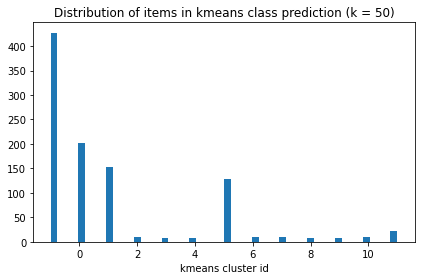

In [60]:
db = OPTICS(min_samples=7)
predicted_k = db.fit_predict(cell_structures)

t = timestamp()
plt.figure()
plt.title('Distribution of items in kmeans class prediction (k = {})'.format(OPT_K))
plt.hist(predicted_k, bins=OPT_K)
plt.xlabel('kmeans cluster id')
#plt.grid(True, which="both", ls="-", alpha=0.5)
plt.tight_layout()
plt.savefig('figures/kmeans_class_dist' + str(t) + '.pdf', dpi=600)
plt.show()

In [61]:
df['class'] = predicted_k

In [62]:
def rank_column(x):
    return [math.floor(i * 10 / OPT_K) for i in stats.rankdata(x, "average")]

In [63]:
by_class = df\
    .groupby(['class'])['test_accuracy', 'validation_accuracy', 'training_time']\
    .agg(['mean', 'std'])

by_class['test_accuracy_rank'] = rank_column(by_class['test_accuracy']['mean'])
by_class['training_time_rank'] = rank_column(by_class['training_time']['mean'])

by_class = by_class.sort_values(['test_accuracy_rank', 'training_time_rank'], ascending=[False, True])
breed = by_class[by_class.training_time_rank.le(3)].head(BREED_LEN).index.to_numpy()
# We are not interested in high computation time
# Thats why we filter out training_time_rank > 3
breed

/Users/volodymyr/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


array([3, 4, 6, 8, 7])

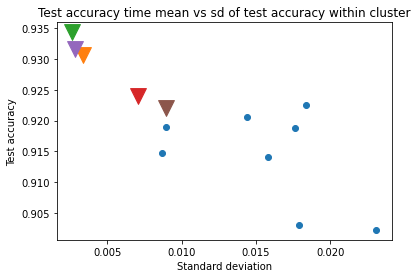

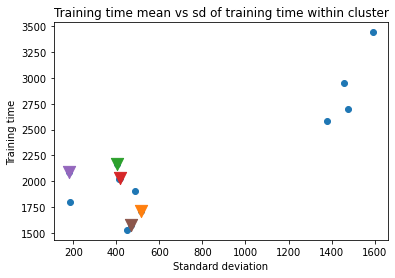

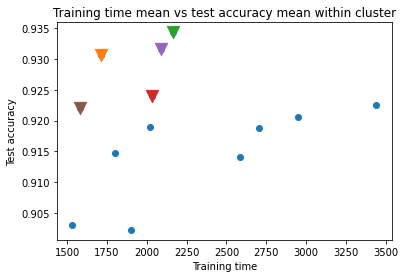

In [64]:
fig, ax = plt.subplots()
ax.scatter(by_class['test_accuracy']['std'],
           by_class['test_accuracy']['mean']
)
for b in breed:
    ax.scatter(
        by_class.loc[b]['test_accuracy']['std'],
        by_class.loc[b]['test_accuracy']['mean'],
        marker = "v",
        s = 250
    )
ax.set_title('Test accuracy time mean vs sd of test accuracy within cluster')
ax.set_ylabel('Test accuracy')
ax.set_xlabel('Standard deviation');
plt.savefig('figures/kmeans_test_mean_sd' + str(t) + '.pdf', dpi=1000)
plt.show()

fig, ax = plt.subplots()
ax.scatter(by_class['training_time']['std'], by_class['training_time']['mean'])
for b in breed:
    ax.scatter(
        by_class.loc[b]['training_time']['std'],
        by_class.loc[b]['training_time']['mean'],
        marker = "v",
        s = 150
    )
ax.set_title('Training time mean vs sd of training time within cluster')
ax.set_ylabel('Training time')
ax.set_xlabel('Standard deviation');
plt.savefig('figures/kmeans_training_time_mean_sd' + str(t) + '.pdf', dpi=1000)
plt.show()

fig, ax = plt.subplots()
ax.scatter(by_class['training_time']['mean'], by_class['test_accuracy']['mean'])
for b in breed:
    ax.scatter(
        by_class.loc[b]['training_time']['mean'],
        by_class.loc[b]['test_accuracy']['mean'],
        marker = "v",
        s = 150
    )
ax.set_title('Training time mean vs test accuracy mean within cluster')
ax.set_ylabel('Test accuracy')
ax.set_xlabel('Training time');
plt.savefig('figures/kmeans_training_time_test_acc_mean' + str(t) + '.pdf', dpi=1000)
plt.show()

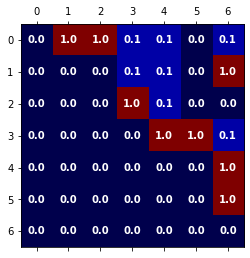

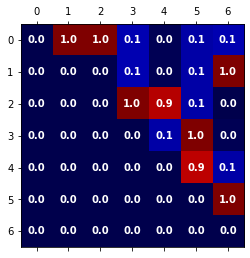

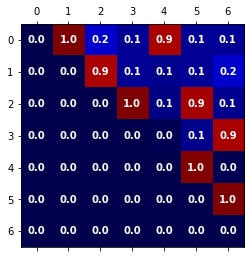

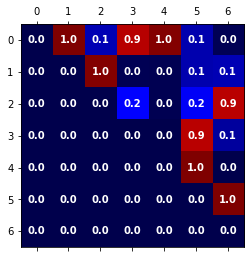

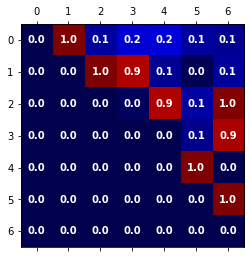

In [65]:
empty_cell = np.zeros((MAX_VERTICES, MAX_VERTICES))
probability_maps = []
for b in breed:
    samples = df[df['class'].eq(b)].index
    heatmap = empty_cell
    for s in samples:
        heatmap += np.asarray(random_cells[str(s)]['matrix'])
    heatmap /= np.amax(heatmap, axis=None)
    plt.matshow(heatmap, cmap = "seismic")
    for (i, j), z in np.ndenumerate(heatmap):
        plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', c='white', weight = "bold")
    plt.show()
    probability_maps.append((heatmap > SIMILARITY_TOLERANCE) * 1)  # Remove values that are lower than tolerance level

/Users/volodymyr/miniconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/volodymyr/miniconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/volodymyr/miniconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/volodymyr/miniconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/volodymyr/miniconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  

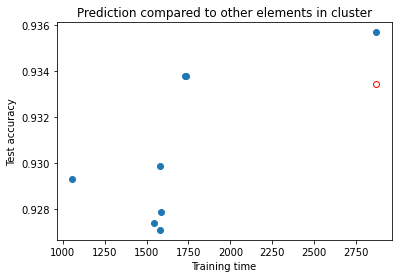

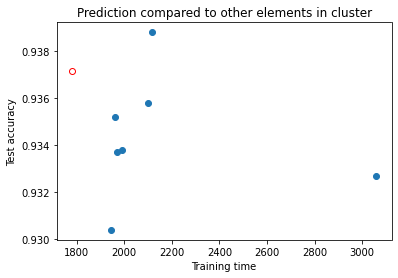

/Users/volodymyr/miniconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/volodymyr/miniconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/volodymyr/miniconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/volodymyr/miniconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/volodymyr/miniconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  

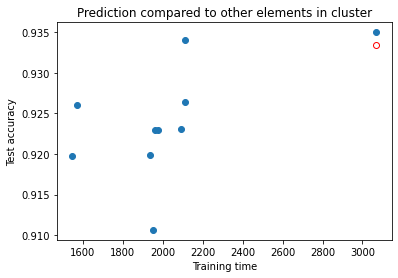

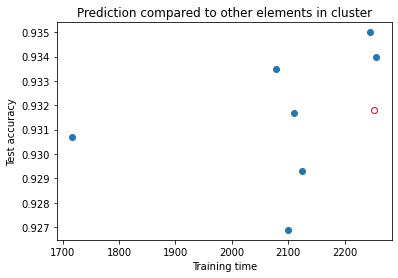

/Users/volodymyr/miniconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/volodymyr/miniconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/volodymyr/miniconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/volodymyr/miniconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/volodymyr/miniconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  

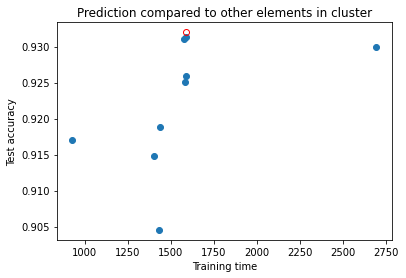

In [66]:
results_acc = []
results_tt = []
optimal_score = []
train_budget = dt.nb.get_budget()[0]
dt.nb.reset_budget()
tr_params = []
adj_matrixes = []
for i in range(0, BREED_LEN):
    class_subset = df[df['class'].eq(breed[i])]
    bo = BOArchitecture(probability_maps[i], np.max(class_subset['training_time']), dt.nb, seed)
    bo.optimize_architecture()
    #bo.plot_convergence()
    d, a = bo.get_best_result()
    adj_matrixes.append(d['module_adjacency'])
    fig, ax = plt.subplots()
    mean_acc = np.sum([el['final_test_accuracy'] for el in a[108]]) / len(a[108])
    mean_tt = np.sum([el['final_training_time'] for el in a[108]]) / len(a[108])
    results_acc.append(mean_acc)
    results_tt.append(mean_tt)
    tr_params.append(d['trainable_parameters'])
    optimal_score.append(mean_acc / mean_tt)
    ax.scatter(class_subset['training_time'], class_subset['test_accuracy'])
    ax.plot(
        np.sum([el['final_training_time'] for el in a[108]]) / len(a[108]),
        np.sum([el['final_test_accuracy'] for el in a[108]]) / len(a[108]),
        marker = "o",
        markerfacecolor="None",
        markeredgecolor='red',
        markeredgewidth=1
    )
    ax.set_title('Prediction compared to other elements in cluster')
    ax.set_ylabel('Test accuracy')
    ax.set_xlabel('Training time');
    plt.savefig('figures/kmeans_training_time_test_acc_mean' + str(t) + '.pdf', dpi=600)
    plt.show()
    #print(d['test_accuracy'] - np.max(df[df['class'].eq(breed[i])]['test_accuracy']))
    #print(d['training_time'] - np.min(df[df['class'].eq(breed[i])]['training_time']))

1588.9173583984375 0.9319911996523539 5758697


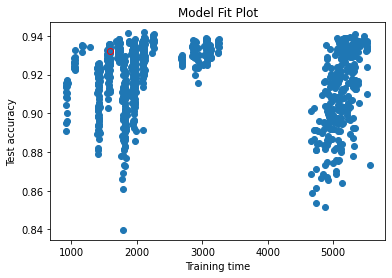

<Figure size 432x288 with 0 Axes>

In [67]:
fig, ax = plt.subplots()
ax.scatter(df['training_time'], df['test_accuracy'])
ax.set_title('Model Fit Plot')
ax.set_ylabel('Test accuracy')
ax.set_xlabel('Training time');
i = optimal_score.index(max(optimal_score))
print(results_tt[i], results_acc[i], tr_params[i])
ax.plot(
    results_tt[i],
    results_acc[i],
    marker = "o",
    markerfacecolor="None",
    markeredgecolor='red',
    markeredgewidth=1
)
plt.show()
plt.savefig('figures/result' + str(t) + '.pdf', dpi=600)

In [31]:
adj_matrixes[i]

array([[0, 1, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0]], dtype=int8)

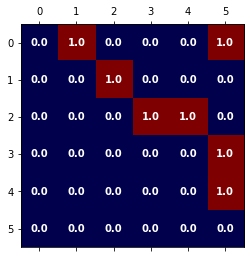

In [32]:
heatmap = adj_matrixes[i]
plt.matshow(heatmap, cmap = "seismic")
for (i, j), z in np.ndenumerate(heatmap):
    plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', c='white', weight = "bold")
plt.show()